# Table of Contents
1. [Business Understanding](#Business-Understanding)

1. [Exploratory Data Analysis and Visualisation](#Exploratory-Data-Analysis)

1. [Churn Modelling](#Churn-Modelling)

    1. [Feature selection and engineering](#Feature-selection-and-engineering)
    1. [Feature preprocessing](#Feature-preprocessing)
    1. [Churn prediction](#Churn-prediction)
    1. [Model tuning](#Model-tuning)
    
1. [Marketing campaign: 20% discount churned custormers](#Marketing-campaign:-20%-discount-churned-customers)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression


pd.set_option('display.max_columns', None)
random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 5)

In [3]:
import os

In [4]:
os.chdir('../data')

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## SME Features (January 2016)

In [7]:
dates = ['contract_activation_date',
         'contract_end_date',
         'contract_fist_act_date',
         'contract_last_mod_date',
         'contract_renewal_date']

In [5]:
train_data = pd.read_csv('aily_case_training_data.csv',
                         index_col='contract_id',
                         # parse_dates=dates
                        )
train_data.head()

,company_category,campaing_code_elect,channel,elect_cons_at_12m,gas_cons_at_12m,elect_cons_last_month,contract_activation_date,contract_end_date,contract_fist_act_date,contract_last_mod_date,contract_renewal_date,fcst_bill_baseline_elect_next_month,fcst_bill_baseline_elect_cal_year,fcst_bill_baseline_elect_12m,fcst_consumption_elect_next_month,fcst_consumption_elect_12m,fcst_consumption_elect_cal_year,fcst_current_discount,fcst_bill_meter_rent_12m,fcst_price_period_1,fcst_price_period_2,fcst_price_power_period_1,client_got_gas,current_paid_consumption,gross_margin_power_elect,net_margin_power_elect,number_active_products,total_net_margin,customer_antiquity_in_years,code_elect_campaign_first_subs,subscribed_power
contract_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d07d473503c6bef7cf1922fab1f88f3e,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1577,0,0,2010-01-05,2016-12-12,NaN,2015-11-01,2015-12-14,NaN,NaN,NaN,NaN,113.189528,0.000000,0.0,9.533935,0.179799,0.000000,29.744311,f,0.000000,40.484555,36.606656,1,9.790569,6,lxidpiddsbxsbosboudacockeimpuepw,13.009751
79e38c743a89ad6b950ae6136bbaeb2b,ixuciffexbsibwibpcwdmfwcoixkfscw,NaN,foosdfpfkusacimwkcsosbicdxkicaua,280731,0,16856,2009-11-04,2016-11-04,NaN,2009-11-04,2015-11-05,NaN,NaN,NaN,NaN,12910.745989,20467.614893,0.0,248.193187,0.139908,0.049123,27.257522,f,1440.595633,-28.777615,-26.021090,1,872.951153,6,lxidpiddsbxsbosboudacockeimpuepw,125.190059
6f6a16ed39fd75715b1acc656c749f83,fmwdwsxillemwbbwelxsampiuwwpcdcb,NaN,foosdfpfkusacimwkcsosbicdxkicaua,99223,189585,4783,2013-02-16,2016-02-16,NaN,2013-02-16,2015-02-18,NaN,NaN,NaN,NaN,622.245387,0.000000,0.0,81.197343,0.151782,0.053042,27.257522,t,0.000000,61.939503,56.006496,2,55.939033,3,lxidpiddsbxsbosboudacockeimpuepw,19.949036
1d8e17bf13218e671e968871e0c6373f,afeccskfmobewicibxofslkxecsuekfi,NaN,foosdfpfkusacimwkcsosbicdxkicaua,10381,0,0,2012-01-25,2017-01-25,NaN,2015-12-16,2016-01-26,NaN,NaN,NaN,NaN,525.026971,0.000000,0.0,89.052476,0.151063,0.052747,27.257522,f,0.000000,94.215208,85.190604,2,53.813449,4,lxidpiddsbxsbosboudacockeimpuepw,30.356086
2c195164c61eeb0edee79688790f3dda,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,6107,0,0,2011-11-12,2016-11-12,2011-11-12,2015-09-20,2015-11-13,0.0,0.0,983.785888,0.0,156.718305,0.000000,0.0,12.829360,0.180165,0.000000,31.082797,f,0.000000,43.562873,39.390111,1,11.044119,4,lxidpiddsbxsbosboudacockeimpuepw,17.338823


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, d07d473503c6bef7cf1922fab1f88f3e to 5844cbd329236f04d75b25d68a7ab279
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company_category                     6551 non-null   object 
 1   campaing_code_elect                  0 non-null      float64
 2   channel                              11878 non-null  object 
 3   elect_cons_at_12m                    16096 non-null  int64  
 4   gas_cons_at_12m                      16096 non-null  int64  
 5   elect_cons_last_month                16096 non-null  int64  
 6   contract_activation_date             16096 non-null  object 
 7   contract_end_date                    16094 non-null  object 
 8   contract_fist_act_date               3508 non-null   object 
 9   contract_last_mod_date               15939 non-null  object 
 10  contract_renewal_date                1605

Let's keep variables with relative small number of NaN values

In [6]:
train_data = train_data[train_data.columns[train_data.isna().sum() < 200]]

In [7]:
len(list(train_data.columns))

23

### Numeric Variables

In [7]:
numerics = ['int64', 'float64']
train_data_num = train_data.select_dtypes(include=numerics)

/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

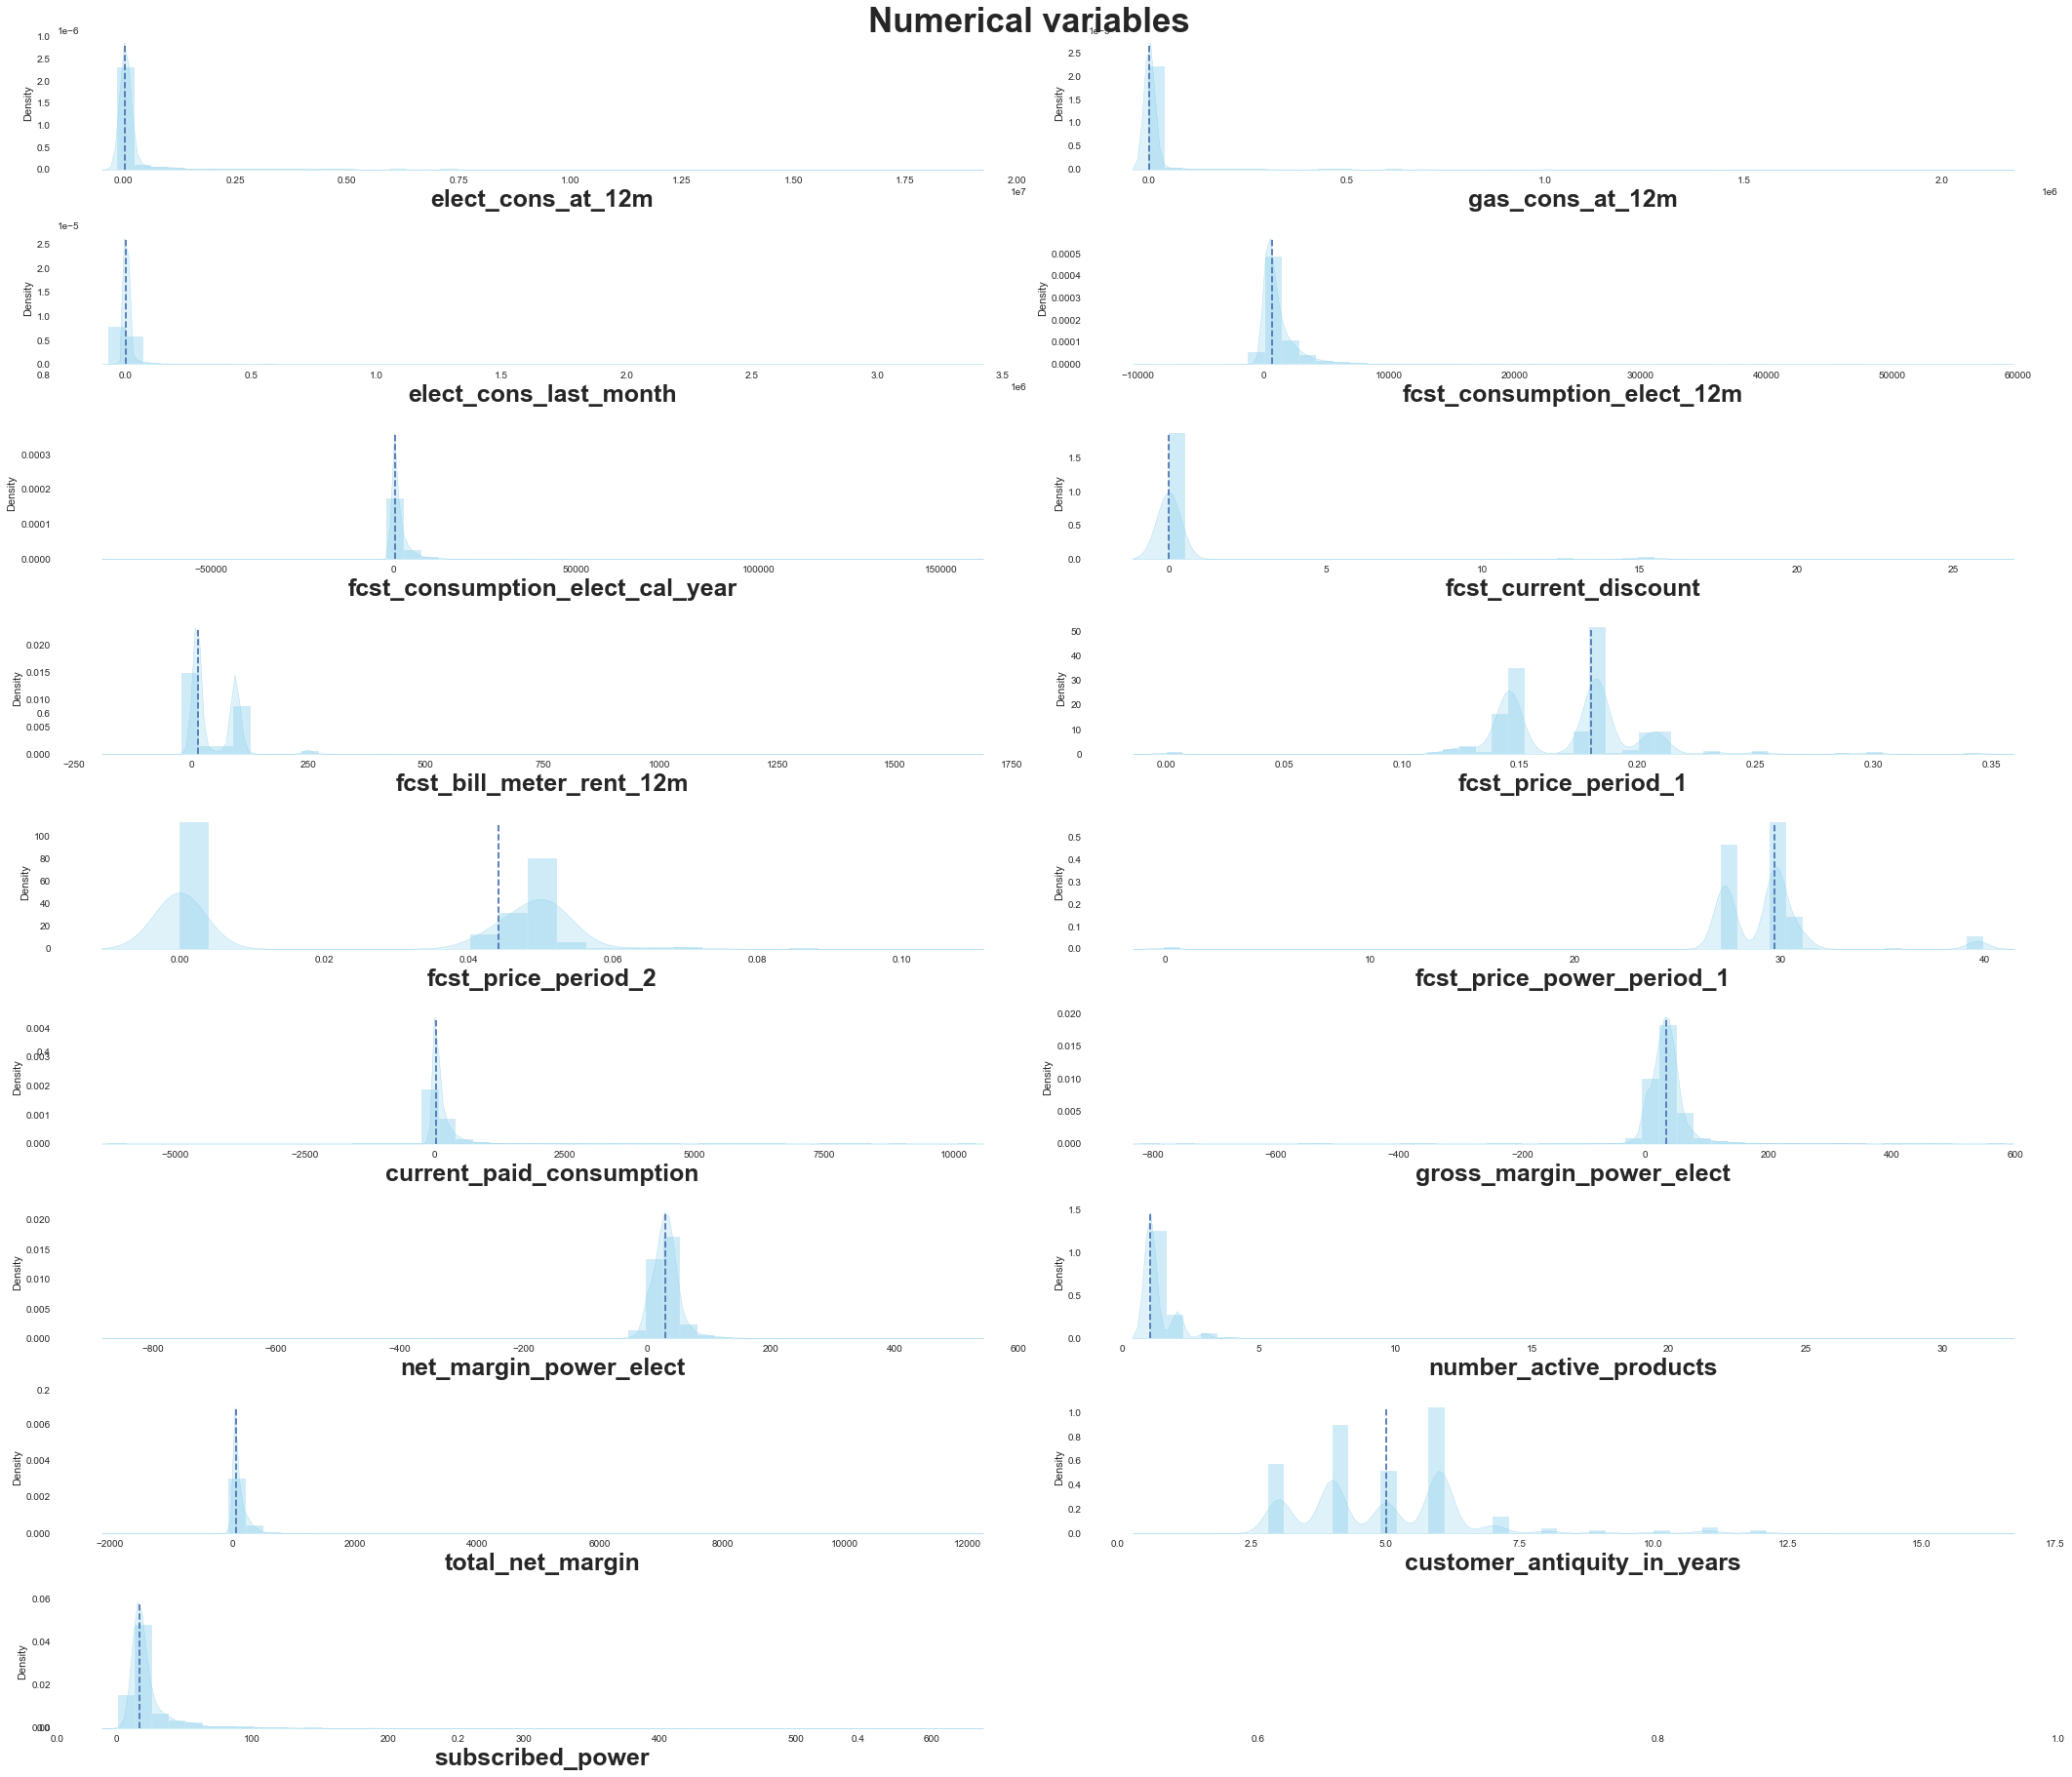

In [31]:
# Set initial plot options
sns.set_style('white')
fig, ax = plt.subplots(figsize = (30, 26))

# Loop over subplots
for i, col in enumerate(train_data_num.columns):
    ax = fig.add_subplot(9, 2, i+1)
    
    sns.distplot(train_data_num[col], 
                 color='skyblue',
                 kde_kws = {"shade":True},
                 kde=True,
                 ax=ax)
    
    # Add a vertical line
    plt.axvline(train_data_num[col].median(), ymax = 0.95, linestyle = "--")
    plt.xlabel(col, fontsize = 25, fontweight = "semibold")
    
# Despine visualizations
sns.despine(left=True)
fig.suptitle("Numerical variables", fontweight = "semibold", fontsize = 35)
    
plt.tight_layout()

plt.savefig('../images/numeric_vars.png')

### Categorical Variables

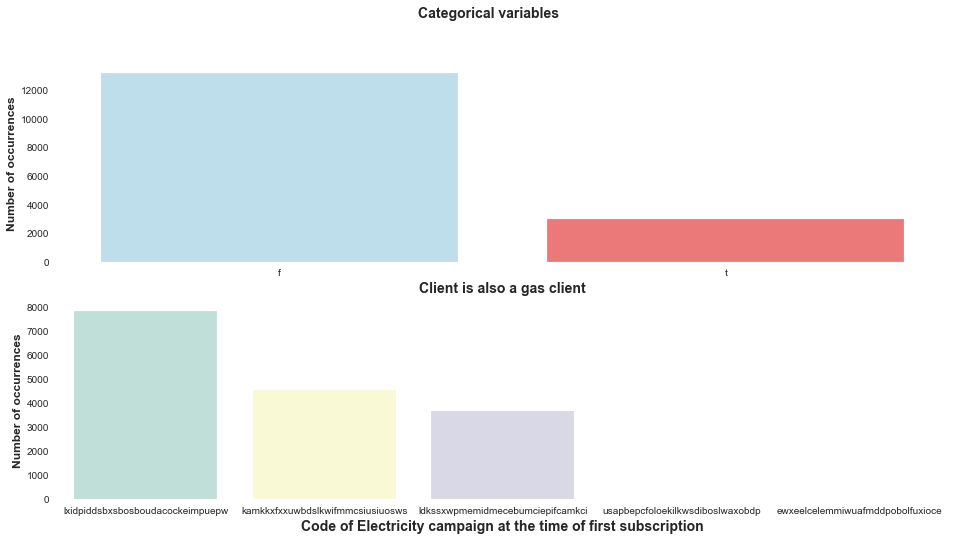

In [18]:
sns.set_style('white')
fig, axes = plt.subplots(2, 1, figsize = (16, 8))

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'client_got_gas',
              data = train_data,
              palette = ['skyblue', 'r'],
              order = ['f', 't'],
              alpha = 0.6,
              ax = axes[0])

# Final styling touche
axes[0].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Client is also a gas client", fontweight = "semibold", fontsize = 14)

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'code_elect_campaign_first_subs',
              data = train_data,
              palette = 'Set3',
              alpha = 0.6,
              ax = axes[1])

# Final styling touche
axes[1].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel('Code of Electricity campaign at the time of first subscription', fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Categorical variables", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/categorical_vars.png')
plt.show()

## Energy and Power prices (2015)

In [12]:
train_data_hist = pd.read_csv('aily_case_training_hist_data.csv',
                              parse_dates=['reference_date'],
                              index_col='contract_id')
train_data_hist.head()

,reference_date,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
contract_id,,,,,,,
cd7ad4a23c39fd588bf326333786300c,2015-02-01,0.136157,0.000000,0.0,39.926856,0.0,0.0
73c63df734c0948948b61dcab3153dce,2015-06-01,0.134560,0.000000,0.0,39.926855,0.0,0.0
75d7981514dd168b8ca9954c62342426,2015-03-01,0.153324,0.067422,0.0,39.926856,0.0,0.0
3d4e8ae29da9e25cf77dd6966ff8c02e,2015-09-01,0.133067,0.000000,0.0,39.926855,0.0,0.0
5c8b795e6ff043528535ef4060416db3,2015-04-01,0.137101,0.000000,0.0,39.926855,0.0,0.0


In [13]:
train_data_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193002 entries, cd7ad4a23c39fd588bf326333786300c to 7d75ec3494d3f99080dfb8cb173c5b90
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   reference_date           193002 non-null  datetime64[ns]
 1   price_energy_1st_period  191643 non-null  float64       
 2   price_energy_2nd_period  191643 non-null  float64       
 3   price_energy_3rd_period  191643 non-null  float64       
 4   price_power_1st_period   191643 non-null  float64       
 5   price_power_2nd_period   191643 non-null  float64       
 6   price_power_3rd_period   191643 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 11.8+ MB


In [14]:
train_data_hist.describe()

,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.127477,0.043164,0.039137,39.077768,8.084069,4.893413
std,0.022710,0.039691,0.046303,4.904798,9.714639,5.899199
min,0.000000,0.000000,0.000000,-0.160349,-0.073866,-0.049402
25%,0.113901,0.000000,0.000000,36.735692,0.000000,0.000000
50%,0.132036,0.067813,0.000000,39.926855,0.000000,0.000000
75%,0.137101,0.080741,0.092463,40.087205,18.392143,12.300087
max,0.253795,0.182288,0.145403,53.616556,27.574100,13.233853


### Time Series Data

In [11]:
energy_melted = pd.melt(train_data_hist, id_vars='reference_date',
                 value_vars=['price_energy_1st_period', 'price_energy_2nd_period', 'price_energy_3rd_period'])

In [12]:
power_melted = pd.melt(train_data_hist, id_vars='reference_date',
                 value_vars=['price_power_1st_period', 'price_power_2nd_period', 'price_power_3rd_period'])

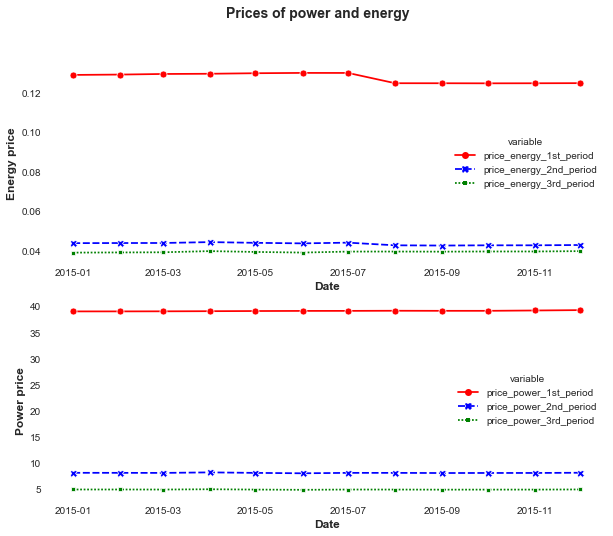

In [13]:
# Set initial plot options
sns.set_style('white')

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Create a lineplot for time series of energy prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = energy_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[0])

# Format subplot in axes
axes[0].set_ylabel("Energy price", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Create a lineplot for time series of power prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = power_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[1])

# Format subplot in axes
axes[1].set_ylabel("Power price", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Despine plot
sns.despine()
plt.suptitle("Prices of power and energy", fontsize = 14, fontweight = "semibold")

plt.savefig('../images/time_series_vars.png')
plt.show()

In [13]:
train_data_hist = train_data_hist.groupby('contract_id').mean()

## Churned customers after a period of 3 months (March 2016)

In [14]:
train_data_output = pd.read_csv('aily_case_training_output.csv',
                                index_col='contract_id')
train_data_output.head()

,has_churned_over_next_3m
contract_id,
6975aab29f35173b43eae4f595b747c7,0
8073016b742f47cf4c76cc41dc410122,1
227c0e6b15256a1d3d3460e15c24ba60,0
e1ea0597bbad7bfd95adf1c7103bfda1,0
a2e017f297f2557a7b1cf4a92bc993e9,0


In [44]:
train_data_output.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 6975aab29f35173b43eae4f595b747c7 to 47204237e076a43d4e60da4bccd05587
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   has_churned_over_next_3m  16096 non-null  int64
dtypes: int64(1)
memory usage: 251.5+ KB


In [19]:
churn_count = train_data_output.groupby('has_churned_over_next_3m').count()
churn_count

""
has_churned_over_next_3m
0
1


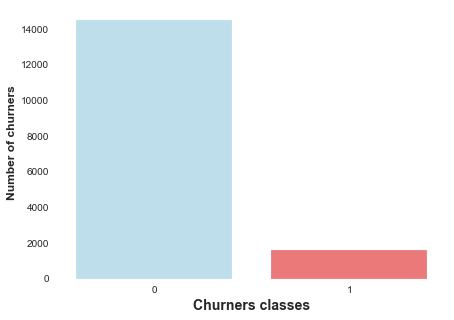

In [16]:
sns.set_style('white')
plt.figure(figsize=(7,5))

# Create a countplot
sns.countplot(x='has_churned_over_next_3m',
              data=train_data_output,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["skyblue", 'r'],
              alpha = 0.6)

# Final styling touche
plt.ylabel("Number of churners", fontsize = 12, fontweight = "semibold")
plt.xlabel("Churners classes", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Distribution of Churners / non-Churners", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churners.png')
plt.show()

## Unified dataset

### Training dataset

In [19]:
train_join = train_data_output.merge(train_data, on='contract_id', how='left')

In [20]:
train_dataset = train_join.merge(train_data_hist, on='contract_id', how='left')

In [22]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 6975aab29f35173b43eae4f595b747c7 to 47204237e076a43d4e60da4bccd05587
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   has_churned_over_next_3m         16096 non-null  int64         
 1   elect_cons_at_12m                16096 non-null  int64         
 2   gas_cons_at_12m                  16096 non-null  int64         
 3   elect_cons_last_month            16096 non-null  int64         
 4   contract_activation_date         16096 non-null  datetime64[ns]
 5   contract_end_date                16094 non-null  datetime64[ns]
 6   contract_last_mod_date           15939 non-null  datetime64[ns]
 7   contract_renewal_date            16056 non-null  datetime64[ns]
 8   fcst_consumption_elect_12m       16096 non-null  float64       
 9   fcst_consumption_elect_cal_year  16096 non-null  float64       
 10  fcst_

### Churn drivers: price

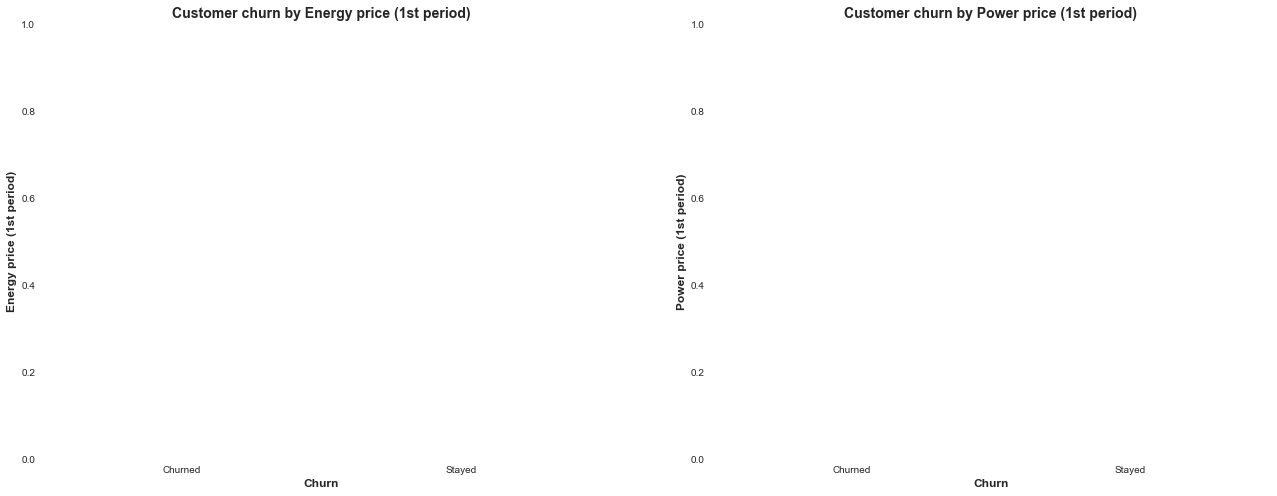

In [23]:
# Set initial plot options
sns.set_style('white')

# Create helper lists
columns_to_plot = ['price_energy_1st_period', 'price_power_1st_period']
titles_to_plot = ["Energy price (1st period)", "Power price (1st period)"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Iterate over each axes, and plot a boxplot with relevant columns/titles
for ax, column, title in zip(axes, columns_to_plot, titles_to_plot):
  
  # Create a boxplot
    sns.boxplot(x = 'has_churned_over_next_3m', 
                # Plot each column from columns_to_plot list
                y = column, 
                data = train_dataset,
                # Set the order for x-axis categories
                order = ["Churned", "Stayed"],
                # Change the width and line-width of each box-plot
                width = 0.4, 
                linewidth = 1.75,
                # Fix colors of churned (red) vs stayed (green)
                palette = ["r", "g"], 
                # Assign boxplot to an axes
                ax = ax)
  
    # Despine plot
    sns.despine()
    # Fix final styling for each axes
    ax.set_xlabel("Churn", fontsize = 12, fontweight = "semibold")
    ax.set_ylabel(title, fontsize = 12, fontweight = "semibold")
    ax.set_title("Customer churn by " + title, fontweight = "semibold", fontsize = 14)
    
plt.savefig('../images/churn_prices.png')
plt.show() 

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='price_power_1st_period'>

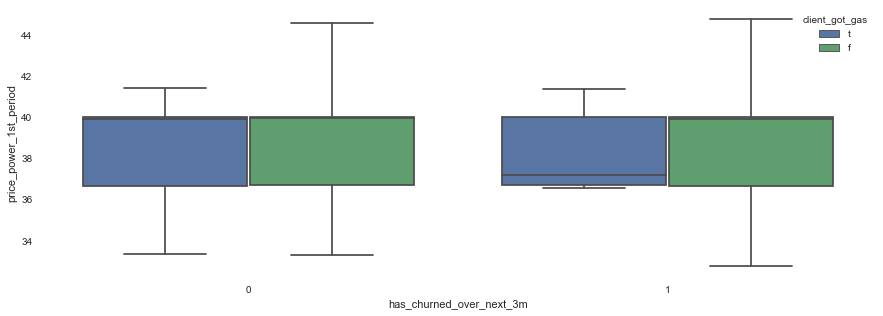

In [30]:
sns.boxplot(x = 'has_churned_over_next_3m',
            y = 'price_power_1st_period',
            data = train_dataset,
            sym = "",
            hue = "client_got_gas")

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='gross_margin_power_elect'>

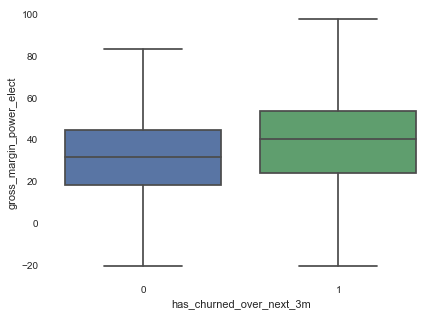

In [36]:
sns.set_style('white')
plt.figure(figsize=(7,5))

sns.boxplot(x = 'has_churned_over_next_3m',
            y = 'gross_margin_power_elect',
            data = train_dataset,
            sym = "",
            )

### Churn drivers: consumption

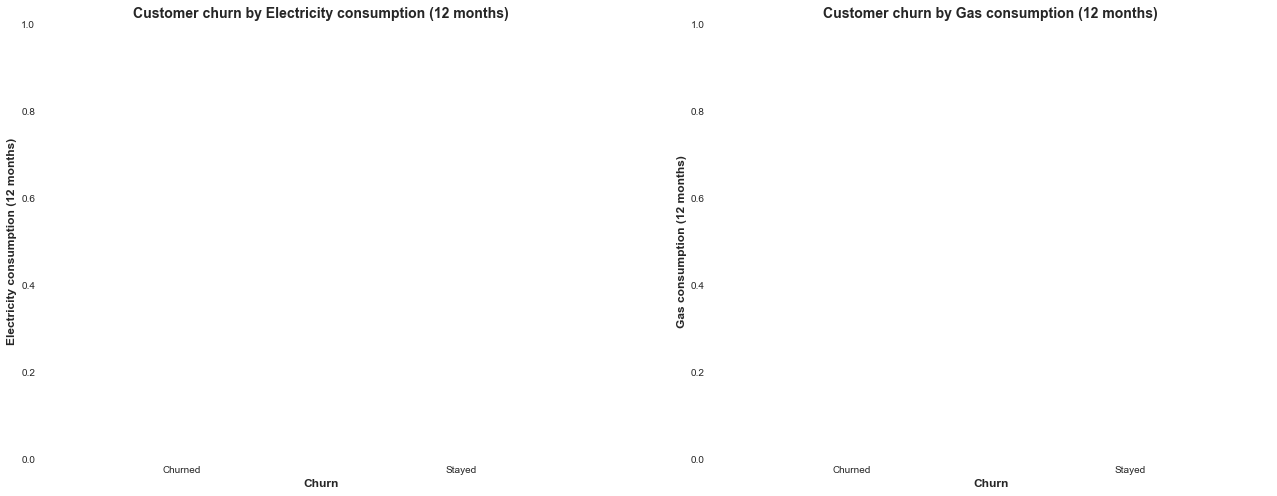

In [37]:
# Set initial plot options
sns.set_style('white')

# Create helper lists
columns_to_plot = ['elect_cons_at_12m', 'gas_cons_at_12m']
titles_to_plot = ["Electricity consumption (12 months)", "Gas consumption (12 months)"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Iterate over each axes, and plot a boxplot with relevant columns/titles
for ax, column, title in zip(axes, columns_to_plot, titles_to_plot):
  
  # Create a boxplot
    sns.boxplot(x = 'has_churned_over_next_3m', 
                # Plot each column from columns_to_plot list
                y = column, 
                data = train_dataset,
                # Set the order for x-axis categories
                order = ["Churned", "Stayed"],
                # Change the width and line-width of each box-plot
                width = 0.4, 
                linewidth = 1.75,
                # Fix colors of churned (red) vs stayed (green)
                palette = ["r", "g"], 
                # Assign boxplot to an axes
                ax = ax)
  
    # Despine plot
    sns.despine()
    # Fix final styling for each axes
    ax.set_xlabel("Churn", fontsize = 12, fontweight = "semibold")
    ax.set_ylabel(title, fontsize = 12, fontweight = "semibold")
    ax.set_title("Customer churn by " + title, fontweight = "semibold", fontsize = 14)
    
plt.savefig('../images/churn_driv_consump.png')
plt.show() 

### Churn drivers: loyalty

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='number_active_products'>

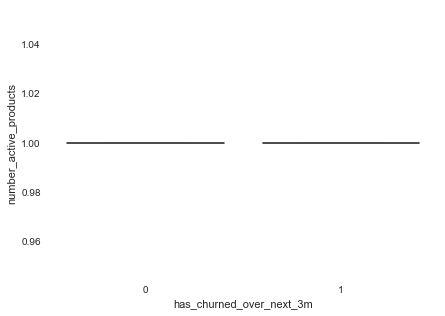

In [39]:
sns.set_style('white')
plt.figure(figsize=(7,5))

# Create a countplot
sns.countplot(x='has_churned_over_next_3m',
              data=train_dataset,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6)

# Final styling touche
plt.ylabel("Number of active products", fontsize = 12, fontweight = "semibold")
plt.xlabel("Churners classes", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Number of active products per customer attrition", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churn_driv_loyalty(1).png')
plt.show()

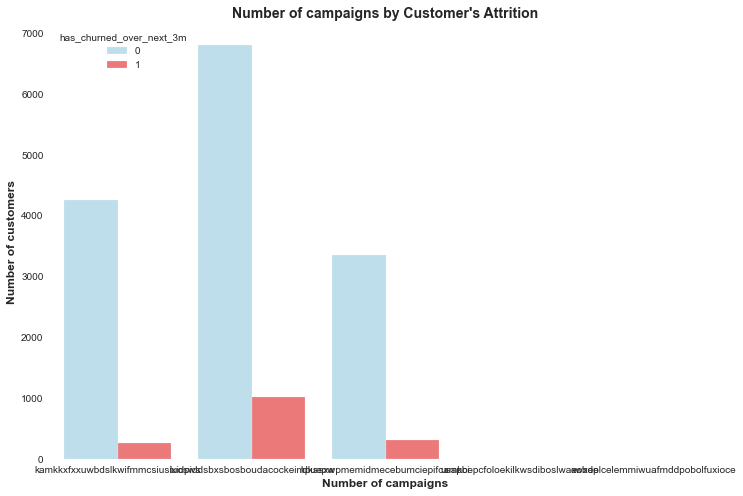

In [43]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (12, 8))

# Create a countplot
sns.countplot(x='code_elect_campaign_first_subs',
              # Group by Gender 
              hue = 'has_churned_over_next_3m', 
              data=train_dataset,
              # Set colour of hue and transperency
              palette = ['skyblue', 'r'],
              alpha = 0.6)

# Despine visualizations
sns.despine()
# Final styling touche
plt.ylabel("Number of customers", fontsize = 12, fontweight = "semibold")
plt.xlabel("Number of campaigns", fontsize = 12, fontweight = "semibold")
#plt.xticks(x, labels, rotation='vertical')
plt.title("Number of campaigns by Customer's Attrition", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churn_driv_loyalty(2).png')
plt.show()

In [41]:
train_dataset.groupby('has_churned_over_next_3m')['contract_renewal_date'].mean()

TypeError: can only concatenate str (not "int") to str

Simple descriptive statistics show that SME churners pay a higher energy/power price despite of having higher subscribed power. Perhaps this is the reason for a less electricity/gas consumption than peers (both on a historical and forecasted basis). They are less loyal (number of active products), though renewal contract date is more recent than for non-churners'. It also seems that first marketing campaign also influences permanence.

### Test dataset

In [ ]:
train_data = pd.read_csv('aily_case_training_data.csv',
                         index_col='contract_id',
                         # parse_dates=dates
                        )
train_data_hist = pd.read_csv('aily_case_training_hist_data.csv',
                              parse_dates=['reference_date'],
                              index_col='contract_id')
train_data_hist = train_data_hist.groupby('contract_id').mean()
train_data_output = pd.read_csv('aily_case_training_output.csv',
                                index_col='contract_id')

In [ ]:
test_join = train_data_output.merge(train_data, on='contract_id', how='left')
test_dataset = train_join.merge(train_data_hist, on='contract_id', how='left')

In [46]:
list(train_dataset.columns)

['has_churned_over_next_3m',
 'elect_cons_at_12m',
 'gas_cons_at_12m',
 'elect_cons_last_month',
 'contract_activation_date',
 'contract_end_date',
 'contract_last_mod_date',
 'contract_renewal_date',
 'fcst_consumption_elect_12m',
 'fcst_consumption_elect_cal_year',
 'fcst_current_discount',
 'fcst_bill_meter_rent_12m',
 'fcst_price_period_1',
 'fcst_price_period_2',
 'fcst_price_power_period_1',
 'client_got_gas',
 'current_paid_consumption',
 'gross_margin_power_elect',
 'net_margin_power_elect',
 'number_active_products',
 'total_net_margin',
 'customer_antiquity_in_years',
 'code_elect_campaign_first_subs',
 'subscribed_power',
 'price_energy_1st_period',
 'price_energy_2nd_period',
 'price_energy_3rd_period',
 'price_power_1st_period',
 'price_power_2nd_period',
 'price_power_3rd_period']

# Churn modelling
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Feature selection and engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [22]:
y_train = train_dataset[['has_churned_over_next_3m']]

In [23]:
X_train = train_dataset.drop('has_churned_over_next_3m', axis=1)

In [28]:
X_train.corr()

,elect_cons_at_12m,gas_cons_at_12m,elect_cons_last_month,fcst_consumption_elect_12m,fcst_consumption_elect_cal_year,fcst_current_discount,fcst_bill_meter_rent_12m,fcst_price_period_1,fcst_price_period_2,fcst_price_power_period_1,current_paid_consumption,gross_margin_power_elect,net_margin_power_elect,number_active_products,total_net_margin,customer_antiquity_in_years,subscribed_power,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
elect_cons_at_12m,1.000000,0.471233,0.919545,0.165168,0.139526,-0.043708,0.085996,-0.033546,0.146758,-0.025418,0.139353,-0.065500,-0.045779,0.308567,0.120491,0.008810,0.102423,-0.025266,0.143993,0.060944,-0.013425,0.064473,0.071301
gas_cons_at_12m,0.471233,1.000000,0.447209,0.059525,0.057619,-0.014945,0.040327,-0.022416,0.078456,-0.027193,0.060609,-0.016867,-0.008242,0.272004,0.058930,-0.008626,0.052365,-0.019198,0.078123,0.047878,-0.022557,0.042964,0.055005
elect_cons_last_month,0.919545,0.447209,1.000000,0.129573,0.151474,-0.037773,0.076064,-0.024241,0.123161,-0.020056,0.153859,-0.054114,-0.037696,0.350710,0.096423,0.004860,0.089564,-0.017434,0.121231,0.048621,-0.010906,0.050955,0.056590
fcst_consumption_elect_12m,0.165168,0.059525,0.129573,1.000000,0.746076,0.014923,0.390550,-0.217315,0.245845,0.058169,0.725550,-0.184179,-0.141642,0.013283,0.768871,0.064431,0.583119,-0.204153,0.248158,0.267394,0.083167,0.307118,0.249098
fcst_consumption_elect_cal_year,0.139526,0.057619,0.151474,0.746076,1.000000,-0.009000,0.329201,-0.206041,0.225691,0.053678,0.981732,-0.139177,-0.106576,0.013811,0.537701,0.066105,0.442228,-0.197909,0.228085,0.238458,0.068733,0.279009,0.216651
fcst_current_discount,-0.043708,-0.014945,-0.037773,0.014923,-0.009000,1.000000,-0.019469,0.319202,0.049174,0.024477,0.011383,0.199609,0.151140,0.055162,0.013500,-0.071723,-0.022646,0.246149,0.030065,0.014396,0.016904,-0.018313,-0.004941
fcst_bill_meter_rent_12m,0.085996,0.040327,0.076064,0.390550,0.329201,-0.019469,1.000000,-0.558751,0.636761,0.013597,0.296259,-0.018957,0.000856,0.000050,0.336343,0.112271,0.600594,-0.525054,0.651259,0.781950,0.044690,0.814531,0.737361
fcst_price_period_1,-0.033546,-0.022416,-0.024241,-0.217315,-0.206041,0.319202,-0.558751,1.000000,-0.364849,0.389218,-0.164657,0.184782,0.029119,0.025854,-0.185221,-0.199922,-0.352961,0.951337,-0.391458,-0.657006,0.338780,-0.687572,-0.634039
fcst_price_period_2,0.146758,0.078456,0.123161,0.245845,0.225691,0.049174,0.636761,-0.364849,1.000000,-0.137244,0.211061,0.063421,0.074075,0.025949,0.251761,0.102997,0.339373,-0.333364,0.994093,0.809582,-0.106030,0.783967,0.796232
fcst_price_power_period_1,-0.025418,-0.027193,-0.020056,0.058169,0.053678,0.024477,0.013597,0.389218,-0.137244,1.000000,0.051517,-0.114822,-0.134192,-0.011416,-0.005513,-0.037951,0.052583,0.384154,-0.143025,-0.179410,0.938099,-0.036942,-0.298614


Pairs of variables with higher correlation rates:
<ul>
    <li><i>fcst_consumption_elect_cal_year</i> and <i>current_paid_consumption</i>: 0.98</li>
    <li><i>fcst_price_period_2</i> and <i>price_energy_2nd_period</i>: 0.99</li>
    <li><i>price_power_2nd_period</i> and <i>price_energy_3rd_period</i>: 0.97</li>
    <li><i>price_power_3rd_period</i> and <i>price_energy_3rd_period</i>: 0.98</li>
</ul><br>
We shall then drop <i>price_energy_3rd_period</i>, <i>fcst_price_period_2</i> (as we keep historical 2nd period energy prices, after removing 3rd period) and <i>fcst_consumption_elect_cal_year</i> (since we already have a forecast consumption on 12 months).

In [24]:
X_train = X_train.drop(['price_energy_3rd_period', 
                        'fcst_price_period_2', 
                        'fcst_consumption_elect_cal_year'],
                        axis=1)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 6975aab29f35173b43eae4f595b747c7 to 47204237e076a43d4e60da4bccd05587
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   elect_cons_at_12m               16096 non-null  int64  
 1   gas_cons_at_12m                 16096 non-null  int64  
 2   elect_cons_last_month           16096 non-null  int64  
 3   contract_activation_date        16096 non-null  object 
 4   contract_end_date               16094 non-null  object 
 5   contract_last_mod_date          15939 non-null  object 
 6   contract_renewal_date           16056 non-null  object 
 7   fcst_consumption_elect_12m      16096 non-null  float64
 8   fcst_current_discount           15970 non-null  float64
 9   fcst_bill_meter_rent_12m        16096 non-null  float64
 10  fcst_price_period_1             15970 non-null  float64
 11  fcst_price_power_period_1       15970 no

FEATURE IMPORTANCES!!!

## Data preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

As of <b>numerical variables</b>, two steps need to be accomplished in a <b>pipeline</b>:
<ol>
    <li> <b>impute NAs</b> with a median strategy (to better account for non-normal distributions),</li>
    <li> <b>standardize variables</b> aiming at <i>normalizing</i> data distributions. We shall use Standard Scaler. Unscaled data can degrade the predictive performance of machine learning algorithms and slow down or even prevent the convergence of many gradient-based estimators.</li>
</ol>
    
[Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
<br>

Regarding <b>categorical variables</b>, we shall have recourse to a <i>column transform</i> method aiming at <b>simultaneously addressing NAs imputation and variable encoding</b>. Let's opt for a <b>Label Encoder</b> for the binary variable and <b>One Hot Encoder</b> for the multiclass variable.<br>

For more information, read this [tutorial](https://www.datacamp.com/community/tutorials/categorical-data) and this [post](https://brendanhasz.github.io/2019/03/04/target-encoding).<br>

As such, the <b>preprocessor object</b> arquitecture consists of the following</b>:<br>

<ol>
    <li> <b>Pipeline</b> for NAs imputation and data scaling of <b>numerical features</b></li>
    <li> <b>Column Transformer</b> for variables (numerical and categorical encoding)</li>
</ol>

Check for reference this [video](https://www.youtube.com/watch?v=Ma-CDFLd03g) (1:17 min onwards).

In [27]:
# Encoding binary feature:
binary_var = ['client_got_gas']
binary_enc = LabelEncoder()

# Encoding multiclass feature:
multiclass_var = ['code_elect_campaign_first_subs']
multiclass_enc = OneHotEncoder()
    
# Numerical features: (i) impute NAs using median strategy, (ii) scale data using StandardScaler
numeric_vars = X_train.select_dtypes(include=['float64', 'int64']).columns.copy()
numeric_transf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessor with a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transf, numeric_vars),
        ('binary_encoder', binary_enc, binary_var),
        ('multiclass_encoder', multiclass_enc, multiclass_var)])

## Churn prediction
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [28]:
# Logistic Regression
clf_lr = LogisticRegression()
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  clf_lr)])

# Fit the model
lr = pipe_lr.fit(X_train, y_train)

# Predict probabilities
# y_pred_lr = pipe_lr.predict_proba(X_test)
# log_loss(y_test, y_pred_lr, eps=1e-15, normalize=True, sample_weight=None, labels=None)

TypeError: fit_transform() takes 2 positional arguments but 3 were given